Ticker dopo filtro market cap: ['MVST', 'VCEL', 'MTX', 'AMPX', 'SHLS', 'GO', 'BLFS', 'CTOS', 'JBI', 'AMPL', 'WVE', 'JANX', 'NGVT', 'UFPT', 'MLKN', 'CLDT', 'WERN', 'PEB', 'NUS']


[*********************100%***********************]  19 of 19 completed



Prime righe del dataset dicembre→gennaio:
  ticker  year  dec_return  jan_return
0   MVST  2019    0.006061    0.000000
1   MVST  2020    0.324555   -0.084211
2   MVST  2021   -0.333333   -0.021201
3   MVST  2022   -0.301370    0.065359
4   MVST  2023    0.196581   -0.330000

Numero osservazioni: 130

=== RISULTATI REGRESSIONE ===
                            OLS Regression Results                            
Dep. Variable:             jan_return   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.554
Date:                Wed, 05 Nov 2025   Prob (F-statistic):              0.112
Time:                        21:49:25   Log-Likelihood:                 67.211
No. Observations:                 130   AIC:                            -130.4
Df Residuals:                     128   BIC:                            -124.7
Df Model:                         

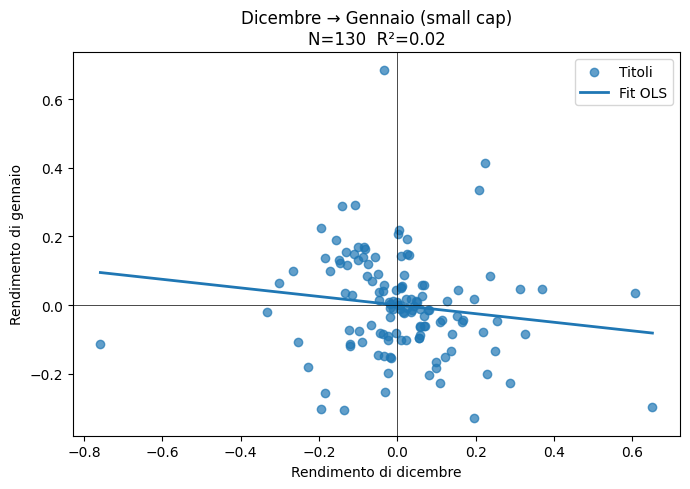

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time

# =========================
# 1) LISTA DI PARTENZA
# =========================
candidate_tickers = [
    "MVST",
    "VCEL",
    "MTX",
    "AMPX",
    "SHLS",
    "GO",
    "BLFS",
    "CTOS",
    "JBI",
    "AMPL",
    "AGYS",
    "KNTK",
    "ACLX",
    "PRVA",
    "IDYA",
    "WVE",
    "JANX",
    "BRZE",
    "RNA",
    "BBIO",
    "EPRT",
    "DY",
    "PECO",
    "SLG",
    "MC",
    "NGVT",
    "UFPT",
    "MLKN",
    "CWK",
    "DAN",
    "HBI",
    "AGTI",
    "CLDT",
    "SPWR",
    "ATNI",
    "WERN",
    "BFH",
    "PEB",
    "RGP",
    "CARG",
    "DOUG",
    "INGN",
    "NUVA",
    "SJW",
    "NUS",
]

# =========================
# 2) FILTRA PER MARKET CAP
#    (small cap circa: 3e8 - 2e9 USD)
# =========================
filtered = []
for t in candidate_tickers:
    try:
        info = yf.Ticker(t).info
        mcap = info.get("marketCap", None)
        if mcap is None:
            continue
        if 3e8 <= mcap <= 2e9:
            filtered.append(t)
        # per non stressare l'API
        time.sleep(0.15)
    except Exception:
        # se per un ticker non arriva l'info, lo saltiamo
        continue

print("Ticker dopo filtro market cap:", filtered)

# se sono pochi, potete anche togliere il filtro e usare direttamente candidate_tickers
tickers = filtered[:50] if filtered else candidate_tickers[:50]

# =========================
# 3) SCARICO DATI MENSILI
# =========================
start_date = "2015-01-01"
end_date = "2024-12-31"

data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    interval="1mo",
    auto_adjust=True,
    group_by="ticker",
    threads=True,
)

# =========================
# 4) COSTRUISCO I RENDIMENTI MENSILI (con PeriodIndex)
# =========================
returns = {}
for t in tickers:
    try:
        close = data[t]["Close"].dropna()
    except Exception:
        continue

    # trasformo l'indice in PeriodIndex mensile: 2024-01, 2024-02, ...
    close.index = close.index.to_period("M")

    ret = close.pct_change().dropna()
    returns[t] = ret

# dataframe con colonne = ticker, index = periodi (M)
returns_df = pd.DataFrame(returns)

# =========================
# 5) COSTRUISCO DATASET DICEMBRE → GENNAIO
#    riga = (ticker, year, dec_return, jan_return)
# =========================
rows = []

# tutti i periodi disponibili
all_periods = returns_df.index.sort_values()

for t in returns_df.columns:
    # per ogni ticker cerchiamo i dicembre e il gennaio successivo
    for p in all_periods:
        if p.month == 12:
            dec_period = p
            jan_period = pd.Period(year=p.year + 1, month=1, freq="M")
            if jan_period in returns_df.index:
                dec_ret = returns_df.at[dec_period, t]
                jan_ret = returns_df.at[jan_period, t]
                # aggiungo solo se non è NaN
                if pd.notna(dec_ret) and pd.notna(jan_ret):
                    rows.append(
                        {
                            "ticker": t,
                            "year": dec_period.year,
                            "dec_return": dec_ret,
                            "jan_return": jan_ret,
                        }
                    )

df_dec_jan = pd.DataFrame(rows)

# opzionale: rimuovo outlier troppo enormi (±100%)
df_dec_jan = df_dec_jan[
    (df_dec_jan["dec_return"].abs() < 1.0) & (df_dec_jan["jan_return"].abs() < 1.0)
]

print("\nPrime righe del dataset dicembre→gennaio:")
print(df_dec_jan.head())
print("\nNumero osservazioni:", len(df_dec_jan))

# =========================
# 6) REGRESSIONE: jan = alpha + beta * dec
# =========================
X = sm.add_constant(df_dec_jan["dec_return"])
y = df_dec_jan["jan_return"]

model = sm.OLS(y, X).fit()
print("\n=== RISULTATI REGRESSIONE ===")
print(model.summary())

# =========================
# 7) PLOT SCATTER + RETTA
# =========================
plt.figure(figsize=(7, 5))
plt.scatter(
    df_dec_jan["dec_return"], df_dec_jan["jan_return"], label="Titoli", alpha=0.7
)

# retta stimata
x_line = np.linspace(
    df_dec_jan["dec_return"].min(), df_dec_jan["dec_return"].max(), 100
)
y_line = model.params["const"] + model.params["dec_return"] * x_line
plt.plot(x_line, y_line, label="Fit OLS", linewidth=2)

plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.xlabel("Rendimento di dicembre")
plt.ylabel("Rendimento di gennaio")
plt.title(
    f"Dicembre → Gennaio (small cap)\nN={len(df_dec_jan)}  R²={model.rsquared:.2f}"
)
plt.legend()
plt.tight_layout()
plt.show()